# HPP with multiple energy markets

## Evaluating the performance of a hybrid power plant using HyDesign

HyDesign is an open-source tool for design and optimization of utility scale wind-solar-storage based hybrid power plants.

In this notebook we will evaluate a hybrid power plant design in a specific location.

A hybrid power plant design consists on selecting the following parameters:

**Wind Turbine design:**

1. Clearance [m] (`clearance`): Height from the ground to rotor tip at lowest posstion. This parameter controls the wind turbine hub height given a rotor radius: `clearance =  HH - R`. 
2. Specific power of the wind turbine [MW/m2] (`sp`): Defined as `sp = p_rated / ( pi * R^2 )`, it controls the turbine rotor size for a given rated power. Turbines with lower specific power produce more power at lower wind speeds, but are more expensive.
3. Rated power of the wind turbine [MW] (`p_rated`)

**Wind Plant design:**

4. Number of wind turbines in the wind plant [-] (`Nwt`)
5. Wind power installation density [MW/km2] (`wind_MW_per_km2`): This parameter controls how closely spaced are the turbines, which in turns affect how much wake losses are present.

**PV Plant design:**

6. Solar plant power capacity [MW] (`solar_MW`)
7. Surface tilt [deg] (`surface_tilt`)
8. Surface azimuth [deg] (`surface_azimuth`)
9. DC-AC ratio [-] (`solar_DCAC`): This parameter controls how much over-planting of PV (in DC power) is connected to the inverters. It is common practice in PV design to have `solar_DCAC = 1.5`. 

**Battery Storage design:**

10. Battery power [MW] (`b_P`)
11. Battery energy capacity in hours [MWh] (`b_E_h `): Battery storage capacity in hours of full battery power (`b_E = b_E_h * b_P `). 
12. Cost of battery power fluctuations in peak price ratio [-] (`cost_of_batt_degr`): This parameter controls how much penalty is given to do ramps in battery power in the HPP operation.


##
**Imports**

Install hydesign if needed.
Import basic libraries. 
Import HPP model assembly class.
Import the examples file path.

In [1]:
# Detect if running in Kaggle
import os 
if os.environ.get('KAGGLE_KERNEL_RUN_TYPE'):
    mypaths = !python -c "import sysconfig; print(sysconfig.get_paths()['purelib'])"
    mypath = mypaths[0]
    !pip install trash-cli
    !trash $mypath/numpy*
    !pip install --upgrade numpy
    !pip install finitediff
    import os
    os.kill(os.getpid(), 9)

In [2]:
# Install hydesign if needed
import importlib
if not importlib.util.find_spec("hydesign"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/hydesign.git    

In [3]:
import os
import time
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from hydesign.assembly.hpp_assembly_BM import hpp_model
from hydesign.examples import examples_filepath

C:\Users\gupta\AppData\Local\Temp\ipykernel_28308\373801245.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


##
**Specifying the site**

Hydesign, provides example data from several sites in India and Europe. 

The site coordinates (longitude, latitude, and altitude) are given in `examples_sites.csv`.

In [4]:
examples_sites = pd.read_csv(f'{examples_filepath}examples_sites.csv', index_col=0, sep=';')
examples_sites

,case,name,longitude,latitude,altitude,input_ts_fn,sim_pars_fn,price_fn,price_col,H2_demand_col,Unnamed: 11,input_HA_ts_fn,price_up_ts,price_dwn_ts
0,India,Indian_site_good_wind,77.500226,8.334294,679.803454,India/GWA2/input_ts_Indian_site_good_wind.csv,India/hpp_pars.yml,India/Indian_elec_price_t.csv,Price,India/H2_demand.csv,NaN,NaN,NaN,NaN
1,India,Indian_site_good_solar,68.542204,23.542099,29.883557,India/GWA2/input_ts_Indian_site_good_solar.csv,India/hpp_pars.yml,India/Indian_elec_price_t.csv,Price,India/H2_demand.csv,NaN,NaN,NaN,NaN
2,India,Indian_site_bad_solar_bad_wind,77.916878,17.292316,627.424643,India/GWA2/input_ts_Indian_site_bad_solar_bad_...,India/hpp_pars.yml,India/Indian_elec_price_t.csv,Price,India/H2_demand.csv,NaN,NaN,NaN,NaN
3,Europe,France_good_solar,4.229736,44.422011,204.000000,Europe/GWA2/input_ts_France_good_solar.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,FR_R,Europe/H2_demand.csv,NaN,NaN,NaN,NaN
4,Europe,France_good_wind,-0.864258,48.744116,302.000000,Europe/GWA2/input_ts_France_good_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,FR_R,Europe/H2_demand.csv,NaN,NaN,NaN,NaN
5,Europe,France_bad_solar_n_wind,2.167969,47.428087,140.000000,Europe/GWA2/input_ts_France_bad_solar_n_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,FR_R,Europe/H2_demand.csv,NaN,NaN,NaN,NaN
6,Europe,Germany_bad_solar_n_wind,10.766602,49.310798,442.000000,Europe/GWA2/input_ts_Germany_bad_solar_n_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DE_ME,Europe/H2_demand.csv,NaN,NaN,NaN,NaN
7,Europe,Germany_good_wind,7.873535,53.287111,5.000000,Europe/GWA2/input_ts_Germany_good_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DE_NW,Europe/H2_demand.csv,NaN,NaN,NaN,NaN
8,Europe,Denmark_good_solar,11.813965,55.397760,42.000000,Europe/GWA2/input_ts_Denmark_good_solar.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DK_E,Europe/H2_demand.csv,NaN,NaN,NaN,NaN
9,Europe,Denmark_good_wind,8.594398,56.227322,85.000000,Europe/GWA2/input_ts_Denmark_good_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DK_W,Europe/H2_demand.csv,NaN,NaN,NaN,NaN


In [5]:
name = 'Denmark_good_wind_BM'
ex_site = examples_sites.loc[examples_sites.name == name]

longitude = ex_site['longitude'].values[0]
latitude = ex_site['latitude'].values[0]
altitude = ex_site['altitude'].values[0]

input_ts_fn = examples_filepath+ex_site['input_ts_fn'].values[0]
sim_pars_fn = examples_filepath+ex_site['sim_pars_fn'].values[0]
input_HA_ts_fn = examples_filepath+ex_site['input_HA_ts_fn'].values[0]
price_up_ts_fn = examples_filepath+ex_site['price_up_ts'].values[0]
price_dwn_ts_fn = examples_filepath+ex_site['price_dwn_ts'].values[0]
price_col = ex_site['price_col'].values[0]

In [6]:
weather_HA = pd.read_csv(input_HA_ts_fn, index_col=0, parse_dates=True)
SO_imbalance = weather_HA['SO_power_imbalance']

## 
**Initializing the HPP model**

Initialize the HPP model (hpp_model class) with the coordinates and the necessary input files.

In [7]:
hpp = hpp_model(
        latitude,
        longitude,
        altitude,
        num_batteries = 5,
        work_dir = './',
        sim_pars_fn = sim_pars_fn,
        input_ts_fn = input_ts_fn,
        input_HA_ts_fn = input_HA_ts_fn,
        price_up_ts_fn = price_up_ts_fn,
        price_dwn_ts_fn = price_dwn_ts_fn,
        price_col = price_col,
)


Fixed parameters on the site
-------------------------------
longitude = 8.594398
latitude = 56.227322
altitude = 85.0


##
### Evaluating the HPP model

In [8]:
start = time.time()

clearance = 10
sp = 350
p_rated = 5
Nwt = 70
wind_MW_per_km2 = 7
solar_MW = 0
surface_tilt = 50
surface_azimuth = 180
solar_DCAC = 1.5
b_P = 100
b_E_h  = 3
cost_of_batt_degr = 2

x = [clearance, sp, p_rated, Nwt, wind_MW_per_km2, \
solar_MW, surface_tilt, surface_azimuth, solar_DCAC, \
b_P, b_E_h , cost_of_batt_degr]

outs = hpp.evaluate(*x)

hpp.print_design(x, outs)

end = time.time()
print(f'exec. time [min]:', (end - start)/60)


Design:
---------------
clearance [m]: 10.000
sp [W/m2]: 350.000
p_rated [MW]: 5.000
Nwt: 70.000
wind_MW_per_km2 [MW/km2]: 7.000
solar_MW [MW]: 0.000
surface_tilt [deg]: 50.000
surface_azimuth [deg]: 180.000
DC_AC_ratio: 1.500
b_P [MW]: 100.000
b_E_h [h]: 3.000
cost_of_battery_P_fluct_in_peak_price_ratio: 2.000


NPV_over_CAPEX: 1.051
NPV [MEuro]: 388.088
IRR: 0.131
revenues [MEuro]: 42.141
LCOE [Euro/MWh]: 48.654
CAPEX [MEuro]: 369.357
OPEX [MEuro]: 5.734
Wind CAPEX [MEuro]: 267.506
Wind OPEX [MEuro]: 5.572
PV CAPEX [MEuro]: 0.000
PV OPEX [MEuro]: 0.000
Batt CAPEX [MEuro]: 35.869
Batt OPEX [MEuro]: 0.162
Shared CAPEX [MEuro]: 65.982
Shared Opex [MEuro]: 0.000
penalty lifetime [MEuro]: 0.000
AEP [GWh]: 711.704
GUF: 0.271
grid [MW]: 300.000
wind [MW]: 350.000
solar [MW]: 0.000
Battery Energy [MWh]: 300.000
Battery Power [MW]: 100.000
Total curtailment [GWh]: 2520.215
Awpp [km2]: 50.000
Apvp [km2]: 0.000
Plant area [km2]: 50.000
Rotor diam [m]: 134.867
Hub height [m]: 77.434
Number of b

In [9]:
b_E_SOC_t = hpp.prob.get_val('ems.b_E_SOC_t')
b_E_SOC_BM_t = hpp.prob.get_val('ems.b_E_SOC_BM_t')
b_SM_t = hpp.prob.get_val('ems.b_t')
b_BM_t = hpp.prob.get_val('ems.b_BM_t')
price_t = hpp.prob.get_val('ems.price_t')
price_up_reg_t = hpp.prob.get_val('ems.price_up_reg_t')
price_dwn_reg_t = hpp.prob.get_val('ems.price_dwn_reg_t')

wind_t = hpp.prob.get_val('ems.wind_t')
wind_BM_t_ext = hpp.prob.get_val('ems.wind_BM_t_ext')
SO_imbalance_t = hpp.prob.get_val('ems.SO_imbalance_t')
hpp_t = hpp.prob.get_val('ems.hpp_t')
hpp_BM_t = hpp.prob.get_val('ems.hpp_BM_t')
hpp_curt_SM_t = hpp.prob.get_val('ems.hpp_curt_t')
hpp_curt_BM_t = hpp.prob.get_val('ems.hpp_curt_BM_t')
price_penalty_BM_t = hpp.prob.get_val('ems.price_penalty_BM_t')
P_hpp_up_t = hpp.prob.get_val('ems.P_hpp_up_t')
P_hpp_dwn_t = hpp.prob.get_val('ems.P_hpp_dwn_t')
P_hpp_up_max_t = hpp.prob.get_val('ems.P_hpp_up_max_t')
P_hpp_dwn_max_t = hpp.prob.get_val('ems.P_hpp_dwn_max_t')
grid_MW = hpp.prob.get_val('ems.G_MW')
hpp_curt_t = hpp_curt_BM_t


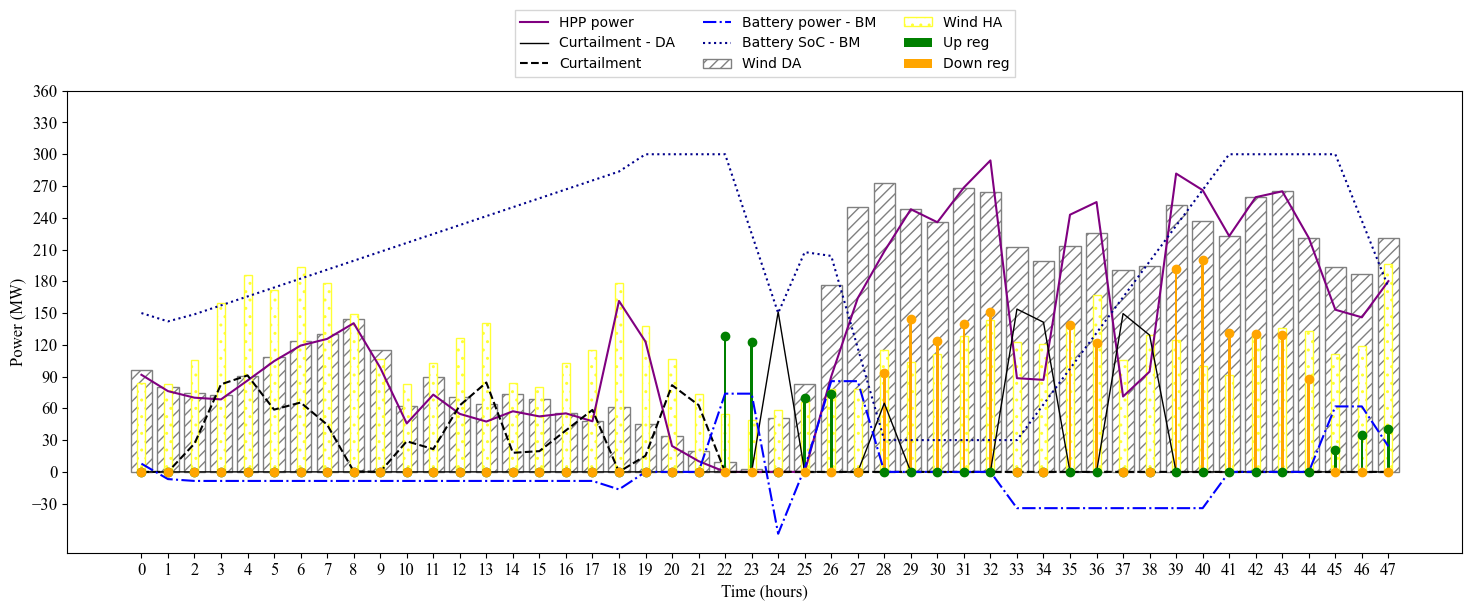

In [13]:
# Create a figure and axis
light_yellow = (1.0, 1.0, 0.2)  # (R, G, B)       
fig, ax = plt.subplots(figsize=(18, 6))
n_days_plot = 2
sd = 0
# Plot wind_DA as a bar and wind_HA as a narrow bar
ax.bar(np.arange(len(wind_t[sd:24*n_days_plot])), wind_t[sd:24*n_days_plot], color='white',width=0.8, hatch='///', edgecolor='grey', label='Wind DA')
ax.bar(np.arange(len(wind_BM_t_ext[sd:24*n_days_plot])), wind_BM_t_ext[sd:24*n_days_plot], color='white', width=0.3, hatch='..', edgecolor=light_yellow, label='Wind HA')

# Line plot for HPP power and curtailment
plt.plot(hpp_t[sd:24*n_days_plot], color='purple', linewidth='1.5', label ='HPP power')
plt.plot(hpp_curt_SM_t[sd:24*n_days_plot], color='black', linewidth='1', label ='Curtailment - DA')
plt.plot(hpp_curt_t[sd:24*n_days_plot], color='black', linestyle='--', linewidth='1.5', label ='Curtailment')
plt.plot(b_BM_t[sd:24*n_days_plot], color='blue', linewidth='1.5', linestyle='-.', label ='Battery power - BM')
plt.plot(b_E_SOC_BM_t[sd:24*n_days_plot], color='darkblue', linestyle=':', linewidth='1.5', label ='Battery SoC - BM')


# Plot Up and down regulation power as a narrow bar with a circle marker at the top
ax.bar(np.arange(len(P_hpp_up_t[sd:24*n_days_plot])), P_hpp_up_t[sd:24*n_days_plot], color='green', width=0.1, align='center', label='Up reg')
ax.scatter(np.arange(len(P_hpp_up_t[sd:24*n_days_plot])), P_hpp_up_t[sd:24*n_days_plot], color='green', zorder=3)

ax.bar(np.arange(len(P_hpp_dwn_t[sd:24*n_days_plot])), P_hpp_dwn_t[sd:24*n_days_plot], color='orange', width=0.1, align='center', label='Down reg')
ax.scatter(np.arange(len(P_hpp_dwn_t[sd:24*n_days_plot])), P_hpp_dwn_t[sd:24*n_days_plot], color='orange', zorder=3)

# # Customize ticks and labels
ax.set_xticks(np.arange(0, 24*n_days_plot))
plt.yticks(np.arange(-30, 361, step=30))
plt.xticks(fontsize=12, fontname='Times New Roman')  # Set font size for x-axis ticks
plt.yticks(fontsize=12, fontname='Times New Roman')  # Set font size for y-axis ticks
plt.xlabel('Time (hours)', fontsize=12, fontname='Times New Roman')  # Set label for x-axis
plt.ylabel('Power (MW)', fontsize=12, fontname='Times New Roman')  # Set label for y-axis
# Add legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.19),
           ncol=3, fancybox=0, shadow=0, fontsize=10)
plt.show()

In [11]:
results = {'Wind SM': wind_t, 'Wind BM': wind_BM_t_ext[:8760], 'HPP power output SM': hpp_t[:8760],'HPP power output BM': hpp_BM_t[:8760], 'Curtailment SM': hpp_curt_SM_t[:8760], 'Curtailment BM': hpp_curt_BM_t[:8760], \
                    'Battery power - SM': b_SM_t[:8760], 'Battery power - BM': b_BM_t[:8760], \
                        'Energy Level': b_E_SOC_t[:8760], 'Up regulation power': P_hpp_up_t[:8760], 'Down regulation power': P_hpp_dwn_t[:8760],\
                            'Max Up regulation': P_hpp_up_max_t[:8760] , 'Max Down regulation': P_hpp_dwn_max_t[:8760] , 'Penalty BM': price_penalty_BM_t[:8760],\
                                 'SM Prices': price_t, 'Up reg prices': price_up_reg_t, 'Down reg prices': price_dwn_reg_t}
df = pd.DataFrame(results)
df.to_csv('EMS_out_9_BM.csv')


In [12]:
design_df = pd.DataFrame(columns = ['NPV_over_CAPEX',
                                            'NPV [MEuro]',
                                            'IRR',
                                            'Revenues [MEuro]',
                                            'LCOE [Euro/MWh]',
                                            'CAPEX [MEuro]',
                                            'OPEX [MEuro]',
                                            'Wind CAPEX [MEuro]',
                                            'Wind OPEX [MEuro]',
                                            'PV CAPEX [MEuro]',
                                            'PV OPEX [MEuro]',
                                            'Batt CAPEX [MEuro]',
                                            'Batt OPEX [MEuro]',
                                            'Shared CAPEX [MEuro]',
                                            'Shared OPEX [MEuro]',
                                            'penalty lifetime [MEuro]',
                                            'AEP [GWh]',
                                            'GUF',
                                            'grid [MW]',
                                            'wind [MW]',
                                            'solar [MW]',
                                            'Battery Energy [MWh]',
                                            'Battery Power [MW]',
                                            'Total curtailment [GWh]',
                                            'Awpp [km2]',
                                            'Apvp [km2]',
                                            'Plant area [km2]',
                                            'Rotor diam [m]',
                                            'Hub height [m]',
                                            'Number of batteries used in lifetime',
                                            'Break-even PPA price [Euro/MWh]',
                                            'Capacity factor wind [-]',
                                            'Execution time [min]',
                                            ]  , index=range(1))
design_df.iloc[0] =  list(outs) + [(end - start)/60]
design_df = design_df.transpose()
design_df.to_csv('output_9_BM.csv')